# Modello realizzato da zero

## Inizializzazione librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
import skimage.io
import glob
import random

from tqdm import tqdm

from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# Instantiating the model for loading the weights and biases and preprocess_input
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers

%matplotlib inline

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"martinacavallucci","key":"1813c6e53fa0a380c7ec0e80fefbebdd"}'}

In [4]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

## Download dataset

In [6]:
! kaggle datasets download -d andrewmvd/leukemia-classification

 99% 862M/867M [00:08<00:00, 87.3MB/s]
100% 867M/867M [00:08<00:00, 107MB/s] 


In [ ]:
! unzip leukemia-classification.zip

## Caricamento nomi immagini dalle cartelle del dataset

In [ ]:
# # delete_test_file = glob.glob('/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/*.bmp')
# # for file in delete_test_file:
# #   os.remove(file)
# !ls

# ! unzip C-NMC_test_prelim_phase_data.zip -d /content/C-NMC_Leukemia/validation_data

In [2]:
import os
import glob
if os.path.exists("./leukemia-classification.zip"):
  os.remove("./leukemia-classification.zip")
# Reading Data
# elimino file non utilizzabili
delete_test_file = glob.glob('./C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
for file in delete_test_file:
  os.remove(file)

train_dataset_0_all = glob.glob('./C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('./C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('./C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

# test_dataset  = glob.glob('./C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
# valid_dataset = glob.glob('./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/*.bmp')

valid_data = pd.read_csv('./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

Definizione proprietà delle immagini

In [3]:
IMAGE_WIDTH = 450
IMAGE_HEIGHT = 450

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

mergin immagini delle differenti classi e delle loro label

In [ ]:
# RGB_SCALE = 255
# CMYK_SCALE = 255


# def rgb_to_cmyk(img):
#     R = img[:,:,0]
#     G = img[:,:,1]
#     B = img[:,:,2]

#     c = 1 - R / RGB_SCALE
#     m = 1 - G / RGB_SCALE
#     y = 1 - B / RGB_SCALE
#     min_cmy = np.minimum(c, np.minimum(m, y))
#     c = ((c - min_cmy) / (1 - min_cmy)) * CMYK_SCALE
#     m = ((m - min_cmy) / (1 - min_cmy)) * CMYK_SCALE
#     y = ((y - min_cmy) / (1 - min_cmy)) * CMYK_SCALE
#     result = np.zeros(img.shape, dtype="uint8")
#     result[:,:,0] = c.astype(int)
#     result[:,:,1] = m.astype(int)
#     result[:,:,2] = y.astype(int)
#     return result

In [4]:
dataset_all = train_dataset_0_all + train_dataset_1_all + train_dataset_2_all
dataset_hem = train_dataset_0_hem + train_dataset_1_hem + train_dataset_2_hem 


label_all =  ["1" for x in range(len(dataset_all))] 
label_hem = ["0" for x in range(len(dataset_hem))] 

dataset = dataset_all + dataset_hem
label = label_all + label_hem

In [ ]:
# with tensorflow.device('/device:GPU:0'):
#   for filename in tqdm(dataset):
#     image = imread(filename)
#     img = rgb_to_cmyk(image)
#     imsave(filename, img)

In [5]:
print("# image All: " + str(len(dataset_all)))
print("# image Hem: " + str(len(dataset_hem)))
print("# image: " + str(len(dataset)))


# image All: 7272
# image Hem: 3389
# image: 10661


## Data Augmetation
In questa fase verà eseguato della data augmetation alle immagini per ottenre un dataset che comprenda 10000 immagini per ogni classe del problema.

### Campionamento delle immagini

In [12]:

NUM_AUGMETATION = 2

augmetedImage_all = random.sample(dataset_all, (10000 - len(dataset_all)))
print("# image To augment (All): " + str(len(augmetedImage_all)))

augmetedImage_hem = random.sample(dataset_hem + dataset_hem, (10000 - len(dataset_hem)))
print("# image To augment (hem): " + str(len(augmetedImage_hem)))



# image To augment (All): 2728
# image To augment (hem): 6611


### Esecuzione Data augmetation

Le operazioni effetuate sulla immagine sono:


1.   Flip casuale in una delle 2 direzioni (verticale / orizontale)
2.   Rotazione casuale
3.   Cropping casuale dell'immgine
4.   modifica casuale del contrasto dell'immagine
5.   Resizing per riportarel e immagini croppate alla dimensione originale






In [ ]:
data_augmentation = tensorflow.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=42),
  layers.experimental.preprocessing.RandomRotation(0.2,seed=42)
])

data_augmentation_whit_crop = tensorflow.keras.Sequential([
  data_augmentation,
  layers.experimental.preprocessing.CenterCrop(400,400),
  layers.experimental.preprocessing.Resizing(450,450)
])

augmeted_all = []
out_folder = "./C-NMC_Leukemia/training_data/fold_a/all/"
if not os.path.exists(out_folder):
  out_folder_a = "./C-NMC_Leukemia/training_data/fold_a"
  os.mkdir(out_folder_a, mode=777)
  os.mkdir(out_folder, mode=777)

with tensorflow.device('/device:GPU:0'):
  for j in tqdm(range(0, len(augmetedImage_all))):
    image = imread(augmetedImage_all[j])
    image2 = tensorflow.expand_dims(image, 0)
    aug_img =  data_augmentation_whit_crop(image2) if j < 1000 else data_augmentation(image2)
    imsave(out_folder + str(j) + '_' + os.path.basename(augmetedImage_all[j]), aug_img[0].numpy())

augmeted_hem = []
out_folder = "./C-NMC_Leukemia/training_data/fold_a/hem/"
if not os.path.exists(out_folder):
  os.mkdir(out_folder, mode=777)
  
with tensorflow.device('/device:GPU:0'):
  for j in tqdm(range(0, len(augmetedImage_hem))):
    image = imread(augmetedImage_hem[j])
    image2 = tensorflow.expand_dims(image, 0)
    aug_img = data_augmentation_whit_crop(image2) if j < 1000 else data_augmentation(image2)
    imsave(out_folder + str(j) + '_' + os.path.basename(augmetedImage_hem[j]), aug_img[0].numpy())


Aggiungo al dataset e alle label le immagini aumentate

In [6]:
train_dataset_a_all = glob.glob('./C-NMC_Leukemia/training_data/fold_a/all/*.bmp')
train_dataset_a_hem = glob.glob('./C-NMC_Leukemia/training_data/fold_a/hem/*.bmp')

dataset = dataset + train_dataset_a_all + train_dataset_a_hem

label_a_all = ["1" for x in range(len(train_dataset_a_all))] 
label_a_hem = ["0" for x in range(len(train_dataset_a_hem))] 

label = label+ label_a_all + label_a_hem

## Preprazione dati e modello
In questa fase vengono preparati i dati per entrare nel modello e viene realizzato il vero e proprio modello

### Preparazione dati

In [7]:
X_val, Y_val = shuffle(dataset, label, random_state = 42)

In [8]:
d = {'filename':X_val, 'category':Y_val}
enteireData = pd.DataFrame(data=d)

train_df, validate_df = train_test_split(enteireData, test_size = 0.20, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)
print(train_df)

                                                filename category
0      ./C-NMC_Leukemia/training_data/fold_a/hem/2497...        0
1      ./C-NMC_Leukemia/training_data/fold_2/all/UID_...        1
2      ./C-NMC_Leukemia/training_data/fold_1/all/UID_...        1
3      ./C-NMC_Leukemia/training_data/fold_2/all/UID_...        1
4      ./C-NMC_Leukemia/training_data/fold_1/hem/UID_...        0
...                                                  ...      ...
15995  ./C-NMC_Leukemia/training_data/fold_a/hem/5748...        0
15996  ./C-NMC_Leukemia/training_data/fold_0/hem/UID_...        0
15997  ./C-NMC_Leukemia/training_data/fold_2/hem/UID_...        0
15998  ./C-NMC_Leukemia/training_data/fold_a/hem/3656...        0
15999  ./C-NMC_Leukemia/training_data/fold_a/hem/1064...        0

[16000 rows x 2 columns]


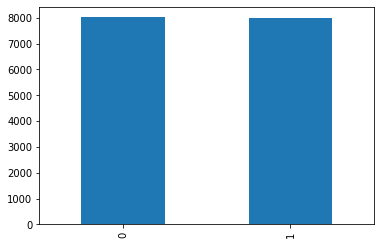

In [9]:
train_df['category'].value_counts().plot.bar()


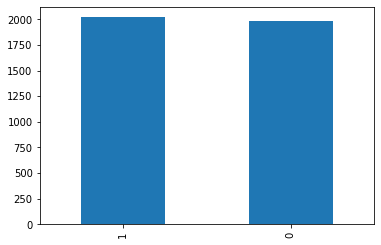

In [18]:
validate_df['category'].value_counts().plot.bar()

In [9]:
batch_size = 128

### Initializzazione generatori

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 16000 validated image filenames belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

validation_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
# example_df = train_df.sample(n = 15).reset_index(drop = True)

# example_generator = train_datagen.flow_from_dataframe(
#     example_df,
#     "./",
#     x_col = 'filename',
#     y_col = 'category',
#     target_size = IMAGE_SIZE,
#     class_mode = 'categorical',
#     batch_size = batch_size
# )

# plt.figure(figsize = (12, 12))

# for i in range(0, 64):
#     plt.subplot(8, 8, i + 1)
    
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break

# plt.tight_layout()
# plt.show()

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

### Preparazione del modello

Definizione delle callback e parametri per il fitting

In [13]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
checkpoint = ModelCheckpoint("Xception_best_model.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")
callbacks = [earlystop, learning_rate_reduction, checkpoint]


In [22]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
base_model = Xception(include_top=False, weights='imagenet', input_shape=(450,450,3))

# Freeze the base_model
base_model.trainable = False

inputs = tensorflow.keras.Input(shape=(450, 450, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)

final_layer = tensorflow.keras.layers.Dense(2, activation = "softmax")(x)
model = tensorflow.keras.Model(inputs, final_layer)
model.compile(
    loss="categorical_crossentropy", 
    metrics = ['accuracy'], 
    optimizer = 'adam'
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 14, 14, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [15]:
epochs = 5
with tensorflow.device('/device:GPU:0'):
  model.fit(
      train_generator, 
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = total_validate // batch_size,
      steps_per_epoch = total_train // batch_size,
      callbacks = callbacks
  )



Epoch 1/5
125/125 [==============================] - 988s 8s/step - loss: 0.5281 - accuracy: 0.7441 - val_loss: 0.4862 - val_accuracy: 0.7724

Epoch 00001: val_accuracy improved from -inf to 0.77243, saving model to Xception_best_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
125/125 [==============================] - 968s 8s/step - loss: 0.4725 - accuracy: 0.7795 - val_loss: 0.4668 - val_accuracy: 0.7848

Epoch 00002: val_accuracy improved from 0.77243 to 0.78478, saving model to Xception_best_model.h5
Epoch 3/5
125/125 [==============================] - 964s 8s/step - loss: 0.4561 - accuracy: 0.7886 - val_loss: 0.4507 - val_accuracy: 0.7921

Epoch 00003: val_accuracy improved from 0.78478 to 0.79209, saving model to Xception_best_model.h5
Epoch 4/5
125/125 [==============================] - 966s 8s/step - loss: 0.4483 - accuracy: 0.7930 - val_loss: 0.4515 - val_accuracy: 0.7886

Epoch 00004: val_accuracy did not improve from 0.79209
Epoch 5/5
125/125 [==============================] - 966s 8s/step - loss: 0.4445 - accuracy: 0.7915 - val_loss: 0.4535 - val_accuracy: 0.7951

Epoch 00005: val_accuracy improved from 0.79209 to 0.79511, saving model to Xception_best_model.h5


In [28]:


model.load_weights("Xception_best_model.h5")



In [30]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
checkpoint = ModelCheckpoint("Xception_best_model2.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")
callbacks2 = [earlystop, learning_rate_reduction, checkpoint]

In [31]:
epochs = 10
model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks2
 )

Epoch 1/10
125/125 [==============================] - 993s 8s/step - loss: 0.4370 - accuracy: 0.8022 - val_loss: 0.4391 - val_accuracy: 0.8014

Epoch 00001: val_accuracy improved from -inf to 0.80141, saving model to Xception_best_model2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
125/125 [==============================] - 999s 8s/step - loss: 0.4346 - accuracy: 0.7996 - val_loss: 0.4359 - val_accuracy: 0.8009

Epoch 00002: val_accuracy did not improve from 0.80141
Epoch 3/10
125/125 [==============================] - 993s 8s/step - loss: 0.4257 - accuracy: 0.8051 - val_loss: 0.4289 - val_accuracy: 0.8082

Epoch 00003: val_accuracy improved from 0.80141 to 0.80822, saving model to Xception_best_model2.h5
Epoch 4/10
125/125 [==============================] - 991s 8s/step - loss: 0.4254 - accuracy: 0.8082 - val_loss: 0.4222 - val_accuracy: 0.8082

Epoch 00004: val_accuracy did not improve from 0.80822
Epoch 5/10
125/125 [==============================] - 984s 8s/step - loss: 0.4224 - accuracy: 0.8083 - val_loss: 0.4234 - val_accuracy: 0.8062

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_accuracy did not improve from 0.80822
Epoch 6/10
125/125 [==============================] - 973s 8s/step - loss: 0.4

In [40]:

from tensorflow.keras.models import load_model
new_model = tensorflow.keras.models.load_model("Xception_best_model2.h5")


In [41]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 14, 14, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [43]:
for i,layer in enumerate(new_model.layers):
  if i < 115:
    layers.trainable = False
  else:
    layer.trainable = True

In [46]:
model.compile(
    loss="categorical_crossentropy", 
    metrics = ['accuracy'], 
    optimizer = 'adam'
)
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
checkpoint =  ModelCheckpoint("final_Xception.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")
callbacks3 = [earlystop, learning_rate_reduction, checkpoint]

In [47]:
epochs = 10

In [ ]:
history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks
)

Epoch 1/10
 34/125 [=======>......................] - ETA: 9:43 - loss: 0.4164 - accuracy: 0.8174

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("%")
plt.xlabel("epoch")
plt.legend(["train accuracy","validation accuracy"], loc="upper left")
plt.show()



In [ ]:
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])
plt.title("Evaluation")
plt.ylabel("")
plt.xlabel("epoch")
plt.legend(["validation accuracy","validation loss"], loc="upper left")
plt.show()

In [ ]:
inp_test_path = "/content/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/"

valid_data_file = [inp_test_path + x for x in valid_data["new_names"]]
valid_data_label = [str(x) for x in valid_data["labels"]]
# with tensorflow.device('/device:GPU:0'):
#   for filename in tqdm(valid_data_file):
#     image = imread(filename)
#     img = rgb_to_cmyk(image)
#     imsave(filename, img)

test_d = {'filename':valid_data_file, 'category':valid_data_label}
enteireData_test = pd.DataFrame(data=test_d)

print(enteireData_test[enteireData_test['category'] == '1'].count())

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
)

test_generator = test_datagen.flow_from_dataframe(
    enteireData_test,
    "./",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

In [ ]:
Y_pred = model.predict_generator(test_generator, enteireData_test.shape[0] // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
from sklearn.metrics import roc_curve
#y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred)

In [ ]:
print('Confusion Matrix')
print(enteireData_test.shape[0])
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = ['Hem', 'All']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.show()

img1 = plot_confusion_matrix(cm = np.array([[183, 465],[317, 902]]), 
                            normalize = False,
                            target_names = ['Hem', 'All'],
                            title = "Confusion Matrix without Normalization")

print("\n\n")

# img2 = plot_confusion_matrix(cm = np.array([[2808,  192],
#                                             [227,  2773]]), 
#                             normalize = True,
#                             target_names = ['all', 'hem'],
#                             title = "Confusion Matrix with Normalization")